# RESEGMENTATION PIPELINE

## Set up source and destination folders

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box


In [2]:
ddir = 'D:\Alexis\Projects\SpatialOmics_cellpose\\results'
base_path = "D:\Alexis\Projects\SpatialOmics_cellpose\data_DRG\output-XETG00245__0058077__Test_Lesion_DRGs__ivCL_DRGs_1__20250806__180812"
# Select first and third hannels for segmentation (can only select three) 
fullres_chanel_0 = f"{base_path}\morphology_focus\morphology_focus_0000.ome.tif"   
fullres_chanel_1 = f"{base_path}\morphology_focus\morphology_focus_0001.ome.tif"
fullres_chanel_3 = f"{base_path}\morphology_focus\morphology_focus_0003.ome.tif"

sample_name = "0058077_ivCL_DRGs_1"

# comment out if don't have ROI
ROI_filepath = f"{base_path}\{sample_name}_coordinates.csv"

# Levels: pixelsize in µm https://kb.10xgenomics.com/hc/en-us/articles/11636252598925
scalefactors = {
    0: 0.2125,
    1: 0.4250,
    2: 0.85,
    3: 1.7,
    4: 3.4,
    5: 6.8,
    6: 13.6,
    7: 27.2,
}

# Define resolution level and crop size in pixels
level = 0
pixelsize = scalefactors[level]

# Define patch size
crop_size = 600/pixelsize

## Define the region of interest (ROI)

In [3]:

def get_all_sections(filepath):
    """Simple parser for ROI file"""
    
    # Skip the header rows and read the data
    coords = pd.read_csv(filepath, skiprows=2)
    
    # Get all unique sections
    sections = coords['Selection'].unique()
    
    print(f"Found {len(sections)} sections:")
    
    all_sections = []
    
    for section in sections:
        section_data = coords[coords['Selection'] == section]
        
        section_info = {
            'name': section,
            'x_coords': section_data['X'].values,
            'y_coords': section_data['Y'].values,
            'num_points': len(section_data)
        }
        
        all_sections.append(section_info)
        print(f"  - {section}: {len(section_data)} points")
    
    return all_sections

def plot_all_sections(all_sections):
    """Plot all sections"""
    
    plt.figure(figsize=(12, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    
    for i, section in enumerate(all_sections):
        color = colors[i % len(colors)]
        
        plt.plot(section['x_coords'], section['y_coords'], 
                'o-', color=color, markersize=3, 
                label=f"{section['name']} ({section['num_points']} pts)", 
                alpha=0.8, linewidth=2)
        
        # Close polygon
        if section['num_points'] > 2:
            plt.plot([section['x_coords'][0], section['x_coords'][-1]], 
                    [section['y_coords'][0], section['y_coords'][-1]], 
                    '-', color=color, alpha=0.8, linewidth=2)
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('All ROI Sections')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

Found 4 sections:
  - Selection 1: 65 points
  - Selection 2: 86 points
  - Selection 3: 88 points
  - Selection 4: 56 points


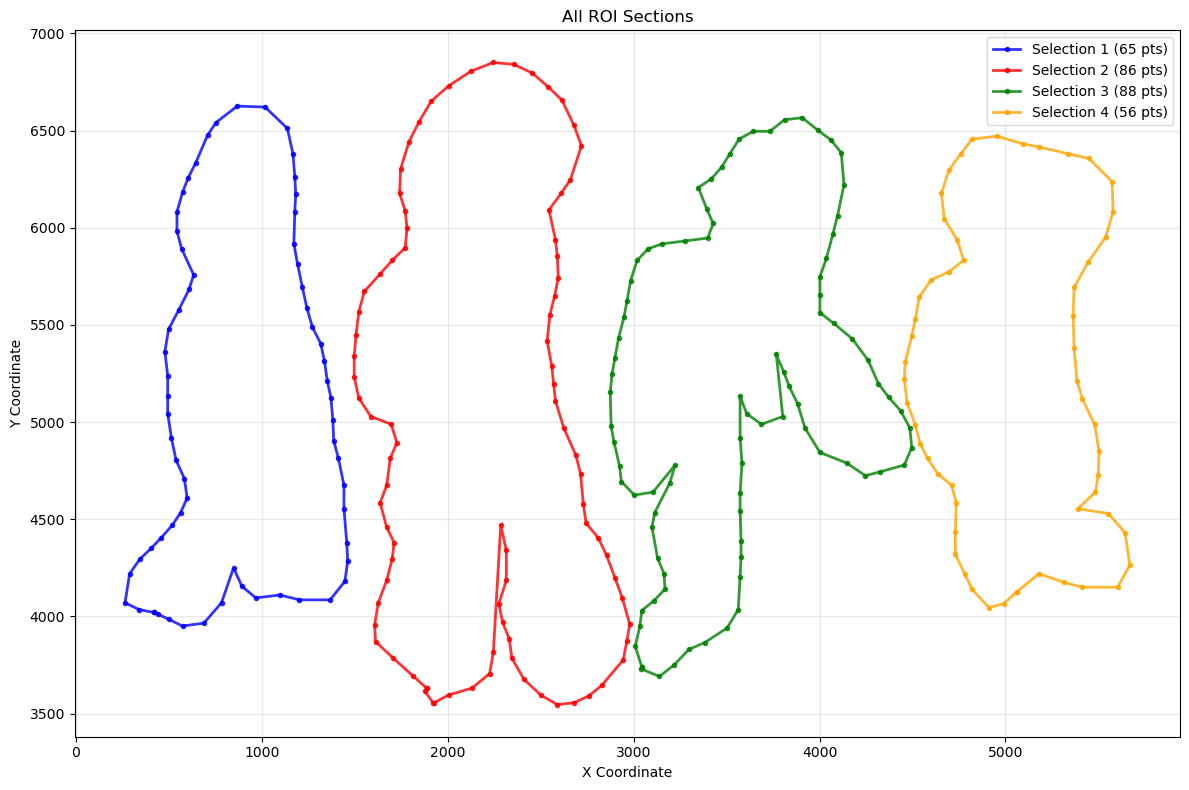

In [4]:
# Get all sections data
all_sections = get_all_sections(ROI_filepath)

# Plot all sections
plot_all_sections(all_sections)

In [5]:
all_sections

[{'name': 'Selection 1',
  'x_coords': array([ 418.38424745,  443.33792497,  498.23601551,  573.09704808,
          687.88396468,  782.70793926,  847.58750082,  892.50412036,
          967.36515292, 1097.12427603, 1201.92972162, 1366.62399327,
         1446.47576134, 1461.44796785, 1456.45723234, 1441.48502583,
         1441.48502583, 1411.54061281, 1386.58693528, 1381.59619978,
         1371.61472877, 1351.65178675, 1336.67958024, 1316.71663822,
         1271.80001868, 1241.85560566, 1216.90192814, 1191.94825061,
         1171.9853086 , 1176.9760441 , 1181.96677961, 1176.9760441 ,
         1166.99457309, 1137.05016007, 1017.27250796,  867.55044283,
          752.76352623,  707.8469067 ,  642.96734514,  603.0414611 ,
          573.09704808,  543.15263505,  543.15263505,  568.10631257,
          632.98587413,  608.03219661,  553.13410606,  498.23601551,
          478.2730735 ,  493.24528001,  493.24528001,  493.24528001,
          513.20822203,  538.16189955,  583.07851909,  598.0507256

In [6]:
# Read the ROI coordinates from the CSV file
from SRC_RESEG.crop_image import *

# # TODO: Comment out if dont have ROI
# plot_roi(ROI_filepath)
# polygon_coords = pd.read_csv(ROI_filepath)

# polygon_coords = all_sections

# # Extract the X and Y coordinates
# x_coords = polygon_coords['X']
# y_coords = polygon_coords['Y']


In [7]:
# mask, masked_img_0 = mask_polygon_from_tif(
#     fullres_chanel_0,
#     x_coords, y_coords,
#     scalefactors,
#     level=0,
#     plot=True
# )

In [8]:
# mask, masked_img_2 = mask_polygon_from_tif(
#     fullres_chanel_2,
#     x_coords, y_coords,
#     scalefactors,
#     level=0,
#     plot=True
# )

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [10]:
# # Combine X and Y into coordinate pairs
# x_coords_rescaled = x_coords / pixelsize
# y_coords_rescaled = y_coords / pixelsize
# rescaled_polygon_roi = list(zip(x_coords_rescaled, y_coords_rescaled))

# # Create a Polygon object
# rescaled_polygon_roi = Polygon(rescaled_polygon_roi)

# # Define square size
# square_size = int(crop_size)
# overlap_size = 40/0.2125

# # Generate non-overlapping square regions
# overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, overlap_size=overlap_size, with_overlap=True)
# non_overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, with_overlap=False)


# plot_polygon_and_squares(
#     rescaled_polygon_roi,
#     overlapping_squares,
#     title="cornea Region & Enclosing Squares",
#     polygon_label="cornea Polygon",
#     square_label="Enclosing Square"
# )

# # for square in overlapping_squares:
# #     print("square:", square)
# #     x, y = square.exterior.xy
# #     print(" x:", x,"\n", "y:", y)


### V2

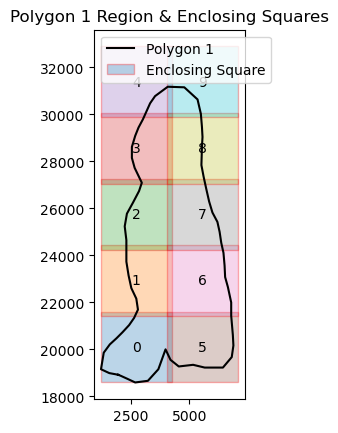

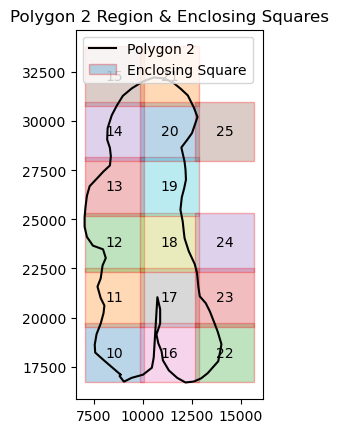

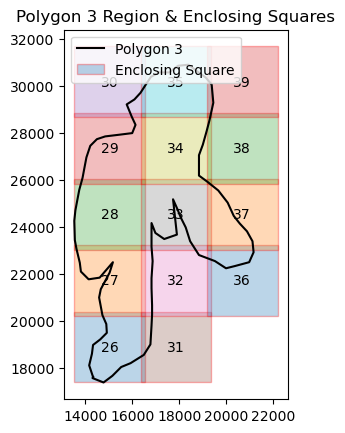

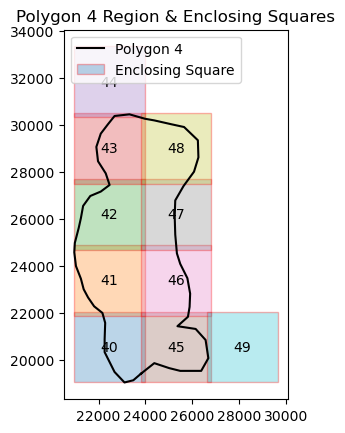

In [11]:
# Process all sections with continuous square numbering
polygon_number = 1
square_counter = 0  # Global square counter

for section in all_sections:
    
    # Get coordinates from section
    x_coords = section['x_coords']
    y_coords = section['y_coords']
    
    # Your original code block (unchanged)
    x_coords_rescaled = x_coords / pixelsize
    y_coords_rescaled = y_coords / pixelsize
    rescaled_polygon_roi = list(zip(x_coords_rescaled, y_coords_rescaled))
    
    # Create a Polygon object
    rescaled_polygon_roi = Polygon(rescaled_polygon_roi)
    
    # Define square size
    square_size = int(crop_size)
    overlap_size = 40/0.2125
    
    # Generate non-overlapping square regions
    overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, overlap_size=overlap_size, with_overlap=True)
    non_overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, with_overlap=False)
    
    # Plot with continuous numbering
    plot_polygon_and_squares_continuous(
        rescaled_polygon_roi,
        overlapping_squares,
        square_counter,  # Pass current counter
        title=f"Polygon {polygon_number} Region & Enclosing Squares",
        polygon_label=f"Polygon {polygon_number}",
        square_label="Enclosing Square"
    )
    
    # Update counters
    square_counter += len(overlapping_squares)  # Increment by number of squares
    polygon_number += 1

In [12]:
print(overlapping_squares)

[<POLYGON ((23979.235 19037, 23979.235 22048.235, 20968 22048.235, 20968 1903...>, <POLYGON ((23979.235 21860, 23979.235 24871.235, 20968 24871.235, 20968 2186...>, <POLYGON ((23979.235 24683, 23979.235 27694.235, 20968 27694.235, 20968 2468...>, <POLYGON ((23979.235 27506, 23979.235 30517.235, 20968 30517.235, 20968 2750...>, <POLYGON ((23979.235 30329, 23979.235 33340.235, 20968 33340.235, 20968 3032...>, <POLYGON ((26802.235 19037, 26802.235 22048.235, 23791 22048.235, 23791 1903...>, <POLYGON ((26802.235 21860, 26802.235 24871.235, 23791 24871.235, 23791 2186...>, <POLYGON ((26802.235 24683, 26802.235 27694.235, 23791 27694.235, 23791 2468...>, <POLYGON ((26802.235 27506, 26802.235 30517.235, 23791 30517.235, 23791 2750...>, <POLYGON ((29625.235 19037, 29625.235 22048.235, 26614 22048.235, 26614 1903...>]


In [13]:
import os

In [14]:

# Load the images first (outside the loop for efficiency)
img0 = tifffile.imread(fullres_chanel_0, is_ome=False, level=0)
img1 = tifffile.imread(fullres_chanel_1, is_ome=False, level=0)
img3 = tifffile.imread(fullres_chanel_3, is_ome=False, level=0)

# # Then in your loop:
# for i, square in enumerate(overlapping_squares):
#     print(f"Processing square {i + 1}:", square)
    
#     # Crop the loaded images (not the file paths)
#     cropped_image_sub0 = crop_region(img0, square)  # Use img0, not fullres_chanel_0
#     cropped_image_sub1 = crop_region(img1, square)  # Use img1, not fullres_chanel_1
#     cropped_image_sub3 = crop_region(img3, square)  # Use img1, not fullres_chanel_1

In [15]:
# Process all sections with continuous square numbering
polygon_number = 1
square_counter = 0  # Global square counter

for section in all_sections:
    print(f"\n=== PROCESSING POLYGON {polygon_number} ===")
    
    # Get coordinates from section
    x_coords = section['x_coords']
    y_coords = section['y_coords']
    
    # Your original code block (unchanged)
    x_coords_rescaled = x_coords / pixelsize
    y_coords_rescaled = y_coords / pixelsize
    rescaled_polygon_roi = list(zip(x_coords_rescaled, y_coords_rescaled))
    
    # Create a Polygon object
    rescaled_polygon_roi = Polygon(rescaled_polygon_roi)
    
    # Define square size
    square_size = int(crop_size)
    overlap_size = 40/0.2125
    
    # Generate squares for this polygon
    overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, overlap_size=overlap_size, with_overlap=True)
    
    print(f"Polygon {polygon_number} has {len(overlapping_squares)} squares")
    
    # Process each square in this polygon - MOVE THIS INSIDE THE POLYGON LOOP
    for i, square in enumerate(overlapping_squares):
        global_square_number = square_counter + i + 1
        print(f"Processing square {global_square_number}: {square}")
        
        # ch 0 Crop the region 
        cropped_image_sub0 = crop_region(img0, square)
        # ch2 Crop the region
        cropped_image_sub1 = crop_region(img1, square)
        # ch2 Crop the region
        cropped_image_sub3 = crop_region(img3, square)
        cropped_image_sub_combined = np.stack((cropped_image_sub0, cropped_image_sub1, cropped_image_sub3), axis=0)
        
        # Check if the folder exists, if not create it
        save_dir = f"{ddir}/cropped_image/{sample_name}"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            print(f"Created directory: {save_dir}")
        
        # Save with continuous numbering
        save_path = f"{save_dir}/cropped_square_com_{global_square_number}.tif"
        tifffile.imwrite(save_path, cropped_image_sub_combined)
        print(f"Cropped image saved to {save_path}")
    
    # Update counters AFTER processing all squares in this polygon
    square_counter += len(overlapping_squares)
    polygon_number += 1
    print(f"Polygon {polygon_number-1} completed. Total squares so far: {square_counter}")

print(f"\n=== FINAL SUMMARY ===")
print(f"Processed {polygon_number-1} polygons")
print(f"Total squares: {square_counter}")


=== PROCESSING POLYGON 1 ===
Polygon 1 has 10 squares
Processing square 1: POLYGON ((4251.235294117647 18591, 4251.235294117647 21602.235294117647, 1240 21602.235294117647, 1240 18591, 4251.235294117647 18591))
Cropped image saved to D:\Alexis\Projects\SpatialOmics_cellpose\results/cropped_image/0058077_ivCL_DRGs_1/cropped_square_com_1.tif
Processing square 2: POLYGON ((4251.235294117647 21414, 4251.235294117647 24425.235294117647, 1240 24425.235294117647, 1240 21414, 4251.235294117647 21414))
Cropped image saved to D:\Alexis\Projects\SpatialOmics_cellpose\results/cropped_image/0058077_ivCL_DRGs_1/cropped_square_com_2.tif
Processing square 3: POLYGON ((4251.235294117647 24237, 4251.235294117647 27248.235294117647, 1240 27248.235294117647, 1240 24237, 4251.235294117647 24237))
Cropped image saved to D:\Alexis\Projects\SpatialOmics_cellpose\results/cropped_image/0058077_ivCL_DRGs_1/cropped_square_com_3.tif
Processing square 4: POLYGON ((4251.235294117647 27060, 4251.235294117647 30071.2

## CELLPOSE - SEGMENTATION

In [16]:
from SRC_RESEG.segmentation_cp import *




Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	win32 
python version: 	3.11.10 
torch version:  	2.7.1+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [17]:
model = models.CellposeModel(gpu=True,
                             pretrained_model='D:\Alexis\Projects\SpatialOmics_cellpose\models\cpsam_Xenium_LDR'
                             )

In [18]:
# Example usage
total = process_images_in_folder(
    input_folder = f'{ddir}/cropped_image/{sample_name}',      
    output_folder = f'{ddir}/segmenatation/{sample_name}',
    cellpose_model = model
)

print(f"Total cells detected: {total}")

channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Processing file: cropped_square_com_1.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_1.tif: 461


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_1.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_1

Processing file: cropped_square_com_10.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_10.tif: 52


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_10.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_10

Processing file: cropped_square_com_11.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_11.tif: 509


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_11.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_11

Processing file: cropped_square_com_12.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_12.tif: 477


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_12.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_12

Processing file: cropped_square_com_13.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_13.tif: 1315


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_13.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_13

Processing file: cropped_square_com_14.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_14.tif: 979


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_14.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_14

Processing file: cropped_square_com_15.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_15.tif: 265


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_15.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_15

Processing file: cropped_square_com_16.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_16.tif: 26


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_16.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_16

Processing file: cropped_square_com_17.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_17.tif: 341


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_17.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_17

Processing file: cropped_square_com_18.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_18.tif: 438


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_18.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_18

Processing file: cropped_square_com_19.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_19.tif: 676


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_19.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_19

Processing file: cropped_square_com_2.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_2.tif: 890


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_2.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_2

Processing file: cropped_square_com_20.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_20.tif: 487


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_20.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_20

Processing file: cropped_square_com_21.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_21.tif: 588


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_21.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_21

Processing file: cropped_square_com_22.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_22.tif: 276


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_22.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_22

Processing file: cropped_square_com_23.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_23.tif: 260


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_23.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_23

Processing file: cropped_square_com_24.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_24.tif: 258


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_24.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_24

Processing file: cropped_square_com_25.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_25.tif: 838


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_25.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_25

Processing file: cropped_square_com_26.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_26.tif: 23


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_26.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_26

Processing file: cropped_square_com_27.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_27.tif: 287


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_27.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_27

Processing file: cropped_square_com_28.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_28.tif: 584


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_28.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_28

Processing file: cropped_square_com_29.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_29.tif: 1396


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_29.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_29

Processing file: cropped_square_com_3.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_3.tif: 961


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_3.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_3

Processing file: cropped_square_com_30.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_30.tif: 752


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_30.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_30

Processing file: cropped_square_com_31.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_31.tif: 22


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_31.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_31

Processing file: cropped_square_com_32.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_32.tif: 229


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_32.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_32

Processing file: cropped_square_com_33.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_33.tif: 128


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_33.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_33

Processing file: cropped_square_com_34.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_34.tif: 588


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_34.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_34

Processing file: cropped_square_com_35.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_35.tif: 812


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_35.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_35

Processing file: cropped_square_com_36.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_36.tif: 525


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_36.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_36

Processing file: cropped_square_com_37.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_37.tif: 236


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_37.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_37

Processing file: cropped_square_com_38.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_38.tif: 704


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_38.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_38

Processing file: cropped_square_com_39.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_39.tif: 142


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_39.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_39

Processing file: cropped_square_com_4.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_4.tif: 382


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_4.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_4

Processing file: cropped_square_com_40.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_40.tif: 5


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_40.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_40

Processing file: cropped_square_com_41.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_41.tif: 364


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_41.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_41

Processing file: cropped_square_com_42.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_42.tif: 1376


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_42.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_42

Processing file: cropped_square_com_43.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_43.tif: 1318


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_43.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_43

Processing file: cropped_square_com_44.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_44.tif: 398


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_44.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_44

Processing file: cropped_square_com_45.tif, shape: (3, 3011, 3011)


no masks found, will not save PNG or outlines


Mask Segmentation Down!
Number of detected regions in cropped_square_com_45.tif: 0


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_45.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_45

Processing file: cropped_square_com_46.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_46.tif: 487


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_46.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_46

Processing file: cropped_square_com_47.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_47.tif: 455


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_47.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_47

Processing file: cropped_square_com_48.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_48.tif: 332


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_48.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_48

Processing file: cropped_square_com_49.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_49.tif: 395


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_49.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_49

Processing file: cropped_square_com_5.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_5.tif: 51


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_5.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_5

Processing file: cropped_square_com_50.tif, shape: (3, 3011, 1866)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_50.tif: 11


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_50.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_50

Processing file: cropped_square_com_6.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_6.tif: 408


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_6.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_6

Processing file: cropped_square_com_7.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_7.tif: 822


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_7.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_7

Processing file: cropped_square_com_8.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_8.tif: 800


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_8.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_8

Processing file: cropped_square_com_9.tif, shape: (3, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_9.tif: 331
Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_9.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1\cropped_square_com_9

Total cells detected: 24460


## Merge

In [19]:
from SRC_RESEG.merge import *

In [20]:
# ROI_filepath = f"{base_path}\{sample_name}_coords.csv"

In [21]:
# Process all sections and collect ALL squares (no image saving)
polygon_number = 1
square_counter = 0
all_overlapping_squares = []      # Collect from all polygons
all_non_overlapping_squares = []  # Collect from all polygons

for section in all_sections:
    print(f"Processing Polygon {polygon_number}...")
    
    # Get coordinates from section
    x_coords = section['x_coords']
    y_coords = section['y_coords']
    
    # Rescale coordinates
    x_coords_rescaled = x_coords / pixelsize
    y_coords_rescaled = y_coords / pixelsize
    rescaled_polygon_roi = list(zip(x_coords_rescaled, y_coords_rescaled))
    
    # Create a Polygon object
    rescaled_polygon_roi = Polygon(rescaled_polygon_roi)
    
    # Define square size
    square_size = int(crop_size)
    overlap_size = 40/0.2125
    
    # Generate squares for this polygon
    overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, overlap_size=overlap_size, with_overlap=True)
    non_overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, with_overlap=False)
    
    # Add squares to the master lists
    all_overlapping_squares.extend(overlapping_squares)
    all_non_overlapping_squares.extend(non_overlapping_squares)
    
    print(f"  - Polygon {polygon_number}: {len(overlapping_squares)} overlapping, {len(non_overlapping_squares)} non-overlapping squares")
    
    polygon_number += 1

print(f"\nTotal squares from all polygons:")
print(f"  - Overlapping squares: {len(all_overlapping_squares)}")
print(f"  - Non-overlapping squares: {len(all_non_overlapping_squares)}")

# Map centroids using ALL squares from ALL polygons
input_dir = f"{ddir}/segmenatation/{sample_name}"

print(f"\nMapping centroids...")
centroids_dict = load_and_offset_centroids(input_dir, all_overlapping_squares)
mapped_df, outside_df, cell_mapping = map_centroids_to_nonoverlapping(centroids_dict, all_non_overlapping_squares)
filtered_outlines_list, outline_info = map_and_filter_outlines(input_dir, all_overlapping_squares, cell_mapping)

print(f"Centroids mapping completed!")

Processing Polygon 1...
  - Polygon 1: 10 overlapping, 10 non-overlapping squares
Processing Polygon 2...
  - Polygon 2: 16 overlapping, 16 non-overlapping squares
Processing Polygon 3...
  - Polygon 3: 14 overlapping, 14 non-overlapping squares
Processing Polygon 4...
  - Polygon 4: 10 overlapping, 10 non-overlapping squares

Total squares from all polygons:
  - Overlapping squares: 50
  - Non-overlapping squares: 50

Mapping centroids...
Found 50 centroid files

Found files:
  cropped_square_com_10_centroids.csv
  cropped_square_com_11_centroids.csv
  cropped_square_com_12_centroids.csv
  cropped_square_com_13_centroids.csv
  cropped_square_com_14_centroids.csv
  cropped_square_com_15_centroids.csv
  cropped_square_com_16_centroids.csv
  cropped_square_com_17_centroids.csv
  cropped_square_com_18_centroids.csv
  cropped_square_com_19_centroids.csv
  cropped_square_com_1_centroids.csv
  cropped_square_com_20_centroids.csv
  cropped_square_com_21_centroids.csv
  cropped_square_com_22_c

Multiprocessing is disabled for Windows


Region 12: Processed 477 outlines
Region 13: Processed 1315 outlines
Region 14: Processed 979 outlines
Region 15: Processed 265 outlines
Region 16: Processed 26 outlines
Region 17: Processed 341 outlines
Region 18: Processed 438 outlines
Region 19: Processed 676 outlines
Region 1: Processed 461 outlines
Region 20: Processed 482 outlines
Region 21: Processed 587 outlines
Region 22: Processed 246 outlines
Region 23: Processed 259 outlines
Region 24: Processed 258 outlines
Region 25: Processed 837 outlines
Region 26: Processed 23 outlines
Region 27: Processed 287 outlines


Multiprocessing is disabled for Windows


Region 28: Processed 584 outlines
Region 29: Processed 1396 outlines
Region 2: Processed 890 outlines
Region 30: Processed 752 outlines
Region 31: Processed 22 outlines
Region 32: Processed 223 outlines
Region 33: Processed 128 outlines
Region 34: Processed 588 outlines
Region 35: Processed 812 outlines
Region 36: Processed 525 outlines
Region 37: Processed 236 outlines
Region 38: Processed 704 outlines
Region 39: Processed 142 outlines
Region 3: Processed 961 outlines
Region 40: Processed 5 outlines


Multiprocessing is disabled for Windows


Region 41: Processed 364 outlines


Multiprocessing is disabled for Windows


Region 42: Processed 1376 outlines
Region 43: Processed 1318 outlines
Region 44: Processed 398 outlines
Region 46: Processed 487 outlines
Region 47: Processed 455 outlines
Region 48: Processed 332 outlines
Region 49: Processed 395 outlines
Region 4: Processed 382 outlines
Region 50: Processed 10 outlines
Region 5: Processed 51 outlines
Region 6: Processed 401 outlines
Region 7: Processed 805 outlines
Region 8: Processed 794 outlines
Region 9: Processed 331 outlines
Centroids mapping completed!


In [22]:
# input_dir = f"{ddir}/segmenatation/{sample_name}"

# # 1. Load and offset centroids
# centroids_dict = load_and_offset_centroids(input_dir, overlapping_squares)

# # 2. Map centroids and get cell mapping
# mapped_df, outside_df, cell_mapping = map_centroids_to_nonoverlapping(centroids_dict, non_overlapping_squares)

# # 3. Load and map outlines
# filtered_outlines_list, outline_info = map_and_filter_outlines(input_dir, overlapping_squares, cell_mapping)



In [23]:

def visualize_mapped_centroids_with_sections(result_df, outside_df, non_overlapping_squares, all_sections, pixelsize, figsize=(15, 15)):
    """
    Visualizes the mapped centroids, squares, and section polygons.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot section polygons first (with alpha)
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    
    for i, section in enumerate(all_sections):
        # Rescale section coordinates
        x_coords_rescaled = section['x_coords'] / pixelsize
        y_coords_rescaled = section['y_coords'] / pixelsize
        
        color = colors[i % len(colors)]
        
        # Plot section boundary
        ax.plot(x_coords_rescaled, y_coords_rescaled, 
                color=color, linewidth=2, alpha=0.5,
                label=f"{section['name']}")
        
        # Fill section area with alpha
        ax.fill(x_coords_rescaled, y_coords_rescaled, 
                color=color, alpha=0.1)
        
        # Close the polygon line
        if len(x_coords_rescaled) > 2:
            ax.plot([x_coords_rescaled[0], x_coords_rescaled[-1]], 
                    [y_coords_rescaled[0], y_coords_rescaled[-1]], 
                    color=color, linewidth=2, alpha=0.5)
    
    # Plot non-overlapping squares
    for idx, square in enumerate(non_overlapping_squares):
        x, y = square.exterior.xy
        ax.plot(x, y, 'k-', linewidth=1, alpha=0.5)
        # Add region number label
        centroid = square.centroid
        ax.text(centroid.x, centroid.y, str(idx + 1), 
                horizontalalignment='center', 
                verticalalignment='center',
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    # Plot mapped centroids
    if not result_df.empty:
        scatter = ax.scatter(result_df['centroid_x'], result_df['centroid_y'], 
                           c=result_df['mapped_region'], 
                           cmap='tab20', 
                           alpha=0.6, 
                           s=20,
                           label='Mapped points')
        # Make colorbar smaller and horizontal under the plot
        cbar = plt.colorbar(scatter, label='Mapped Region', 
                           orientation='horizontal', 
                           shrink=0.6, 
                           aspect=30,
                           pad=0.1)
    
    ax.set_title('Mapped Centroids with Section Boundaries and Regions')
    # Make the legend font smaller by setting fontsize
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

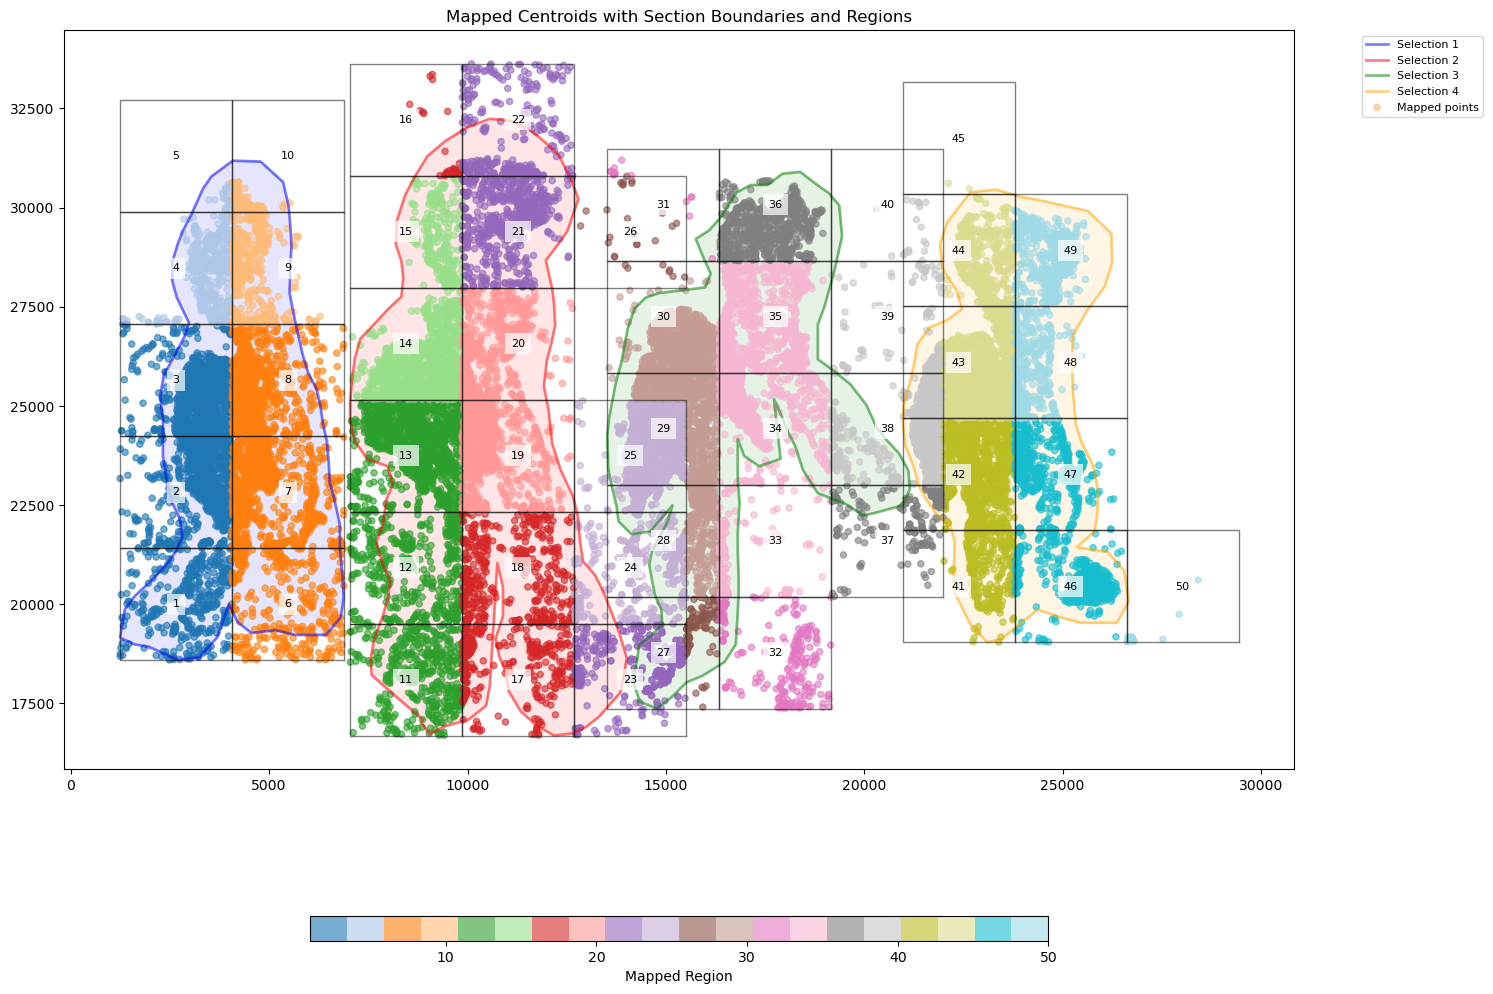


Results saved to: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/0058077_ivCL_DRGs_1


In [24]:
# 4. Visualize results
visualize_mapped_centroids_with_sections(mapped_df, outside_df, all_non_overlapping_squares, all_sections, pixelsize)

# 5. Save results
output_dir = input_dir
mapped_df.to_csv(os.path.join(output_dir, 'mapped_centroids.csv'), index=False)
if not outside_df.empty:
    outside_df.to_csv(os.path.join(output_dir, 'unmapped_centroids.csv'), index=False)
outline_info.to_csv(os.path.join(output_dir, 'outline_mapping.csv'), index=False)
print(f"\nResults saved to: {output_dir}")

In [25]:
# # Function to map segmentation outlines back to original coordinates
# def map_to_original_coordinates(outlines, offset):

#     min_x, min_y = offset
    
#     return [outline + np.array([min_x, min_y]) for outline in outlines]

# outlines_list = []


# # Example processing loop for 3 cropped regions
# for i, square in enumerate(overlapping_squares):
    
#     # Stop the loop when i = 30 if 6 picture, set i + 1 = 5
#     if i + 1 == 29:
#         i1 = i + 1
#         print("Reached the stopping condition: number = {i1}. Exiting the loop.")
#         break

#     print(f"Processing square {i + 1}: {square}")
    
#     # Get bounding box of the current polygon (cropped region)
#     min_x, min_y, max_x, max_y = map(int, square.bounds)

#     # Load the segmentation result for the cropped region
#     # segmentation_file = f"{ddir}/segmenatation/{sample_name}/cropped_square_com_{i + 1}_seg.npy"
#     segmentation_file = f"{ddir}/segmenatation/{sample_name}/cropped_square_com_{i + 1}_seg.npy"
#     segmentation_data = np.load(segmentation_file, allow_pickle=True).item()
    
#     # Extract outlines from    the segmentation
#     outlines = utils.outlines_list(segmentation_data['masks'])

#     # Map outlines back to original coordinates
#     mapped_outlines = map_to_original_coordinates(outlines, (min_x, min_y))
#     outlines_list.extend(mapped_outlines)

In [26]:
 # reuse previous function

In [27]:
df_outlines_list = boundaries_to_table(filtered_outlines_list)

import pandas as pd

def close_cell_boundaries(df):
    closed_df = []

    for cell_id, group in df.groupby('cell_id'):
        group_closed = pd.concat([group, group.iloc[[0]]])  # Append first row at end
        closed_df.append(group_closed)

    return pd.concat(closed_df).reset_index(drop=True)

df_outlines_list = close_cell_boundaries(df_outlines_list)



In [28]:
df_outlines_list.to_csv(f"{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_origian_{sample_name}.csv", index=False)
print("Saved successly" )

Saved successly


In [29]:
# # Apply the function
# reduced_outlines_list = reduce_points(df_outlines_list)

# # Print the results
# print("Original shape:", df_outlines_list.shape)
# print("Reduced shape:", reduced_outlines_list.shape)

In [30]:
# # Visulize before reduce size
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_cell_outlines_comparison(df_orig, df_reduced, n=30, rows=5, cols=6):
#     # find cell IDs present in both dataframes
#     common_ids = np.intersect1d(df_orig['cell_id'].unique(),
#                                 df_reduced['cell_id'].unique())
#     # sample up to n cells
#     ids = np.random.choice(common_ids, min(n, len(common_ids)), replace=False)

#     fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
#     axes = axes.flatten()
#     for ax, cell_id in zip(axes, ids):
#         orig = df_orig[df_orig['cell_id'] == cell_id]
#         red  = df_reduced[df_reduced['cell_id'] == cell_id]

#         # original outline
#         ax.plot(orig['vertex_x'], orig['vertex_y'],
#                 linewidth=2, label='Original', alpha=0.6)
#         # reduced outline
#         ax.plot(red['vertex_x'],  red['vertex_y'],
#                 linewidth=2, linestyle='--', label='Reduced', alpha=0.6)

#         ax.set_title(f'Cell {cell_id}', fontsize=8)
#         ax.invert_yaxis()
#         ax.axis('off')
#         ax.legend(loc='lower right', fontsize=6)

#     # turn off any extra axes
#     for ax in axes[len(ids):]:
#         ax.axis('off')

#     plt.tight_layout()
#     plt.show()

# # usage
# plot_cell_outlines_comparison(df_outlines_list, reduced_outlines_list)



In [31]:
# TODO: SAVE BOUNDARIES ONE BY ONE

In [32]:
# Don't reduced points here
df_outlines_list.to_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_{sample_name}.csv', index=False)
print("Saved successly" )

Saved successly


In [33]:
unique_cell_count = df_outlines_list['cell_id'].nunique()
# unique_cell_count = boundary_df['cell_id'].nunique()

unique_cell_count

24385

In [34]:
# Calculate centroids for each cell
centroids_df = calculate_centroids(df_outlines_list)
centroids_df

,cell_id,centroid_x,centroid_y
0,1,4586.137725,29896.089820
1,2,4649.032000,29898.104000
2,3,4466.661765,29909.156863
3,4,4342.023810,29945.199405
4,5,4400.473684,29905.991228
...,...,...,...
24380,24381,4687.636905,30041.500000
24381,24382,4463.755906,30034.125984
24382,24383,4710.614173,30049.251969
24383,24384,5340.161290,30048.516129


In [35]:
centroids_df_scaled = centroids_df.copy()
rescale_factor = 0.2125
centroids_df_scaled['centroid_x'] *= rescale_factor
centroids_df_scaled['centroid_y'] *= rescale_factor

In [36]:
centroids_df_scaled.to_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_centroids_{sample_name}.csv', index=False)
print("Saved successly" )

Saved successly


In [37]:
# TODO: SAVE CNETROIDS ONE BY ONE

In [38]:
# Process to append the first row of each cell group
Outlines_list_final = (
    df_outlines_list.groupby('cell_id', group_keys=False)
    .apply(lambda group: pd.concat([group, group.iloc[[0]]], ignore_index=True))
)

Outlines_list_final

C:\Users\Alexis\AppData\Local\Temp\ipykernel_44596\3586336543.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.concat([group, group.iloc[[0]]], ignore_index=True))


,cell_id,vertex_x,vertex_y
0,1,4565,29885
1,1,4564,29886
2,1,4563,29886
3,1,4562,29886
4,1,4561,29886
...,...,...,...
89,24385,4525,30055
90,24385,4524,30055
91,24385,4523,30055
92,24385,4522,30055


In [39]:
Outlines_list_final_scaled = Outlines_list_final.copy()
rescale_factor = 0.2125
Outlines_list_final_scaled['vertex_x'] *= rescale_factor
Outlines_list_final_scaled['vertex_y'] *= rescale_factor

In [40]:
Outlines_list_final.to_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_pixel_{sample_name}.csv', index=False)
print("Saved successly" )

Saved successly


In [41]:
Outlines_list_final_scaled.to_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_{sample_name}.csv', index=False)
print("Saved successly" )

Saved successly


## Assign Transcripts

In [42]:
import pandas as pd
boundaries_df_origin = pd.read_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_{sample_name}.csv')
print("Data boundaries table file successfully")

boundaries_df_origin

Data boundaries table file successfully


,cell_id,vertex_x,vertex_y
0,1,970.0625,6350.5625
1,1,969.8500,6350.7750
2,1,969.6375,6350.7750
3,1,969.4250,6350.7750
4,1,969.2125,6350.7750
...,...,...,...
3273168,24385,961.5625,6386.6875
3273169,24385,961.3500,6386.6875
3273170,24385,961.1375,6386.6875
3273171,24385,960.9250,6386.6875


In [43]:
boundaries_df = boundaries_df_origin

In [44]:
transcripts_original = pd.read_parquet(f'{base_path}/transcripts.parquet')

# Print information about the data frame
transcripts_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57123651 entries, 0 to 57123650
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   transcript_id      uint64 
 1   cell_id            object 
 2   overlaps_nucleus   uint8  
 3   feature_name       object 
 4   x_location         float32
 5   y_location         float32
 6   z_location         float32
 7   qv                 float32
 8   fov_name           object 
 9   nucleus_distance   float32
 10  codeword_index     int32  
 11  codeword_category  object 
 12  is_gene            bool   
dtypes: bool(1), float32(5), int32(1), object(4), uint64(1), uint8(1)
memory usage: 3.5+ GB


In [45]:
# Filter transcripts with qv score > 20
transcripts_b4_assign = transcripts_original[transcripts_original['qv'] > 20]

# Print information about the filtered dataframe
print("Original number of transcripts:", len(transcripts_original))
print("Number of transcripts after filtering (qv > 20):", len(transcripts_b4_assign))
print("\nPercentage of transcripts retained:", 
      round(len(transcripts_b4_assign) / len(transcripts_original) * 100, 2), "%")

# Display first few rows of filtered dataframe
print("\nFirst few rows of filtered data:")
print(transcripts_b4_assign.head())

Original number of transcripts: 57123651
Number of transcripts after filtering (qv > 20): 38644131

Percentage of transcripts retained: 67.65 %

First few rows of filtered data:
     transcript_id     cell_id  overlaps_nucleus feature_name  x_location  \
0  281586645877357  UNASSIGNED                 0       Adgrf5   29.515625   
1  281586645862712  UNASSIGNED                 0        Anxa6  107.375000   
2  281586645889734  UNASSIGNED                 0       Atp5f1  178.640625   
3  281586645885930  UNASSIGNED                 0        Bnip3  214.093750   
4  281586645874881  UNASSIGNED                 0        Cryab   21.890625   

   y_location  z_location     qv fov_name  nucleus_distance  codeword_index  \
0  2925.06250   12.734375  23.50       Q2        613.078125            6938   
1  2981.03125   12.500000  40.00       Q2        518.656250            8737   
2  2964.96875   12.750000  40.00       Q2        462.781250            7356   
3  2994.12500   13.062500  23.50       Q2  

In [46]:
processed_count = 0


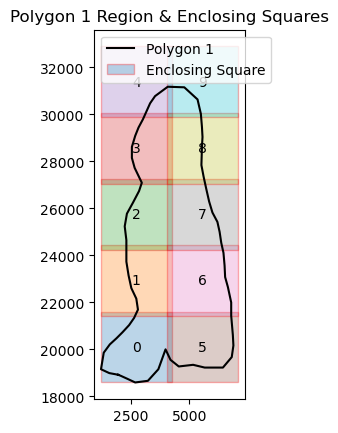

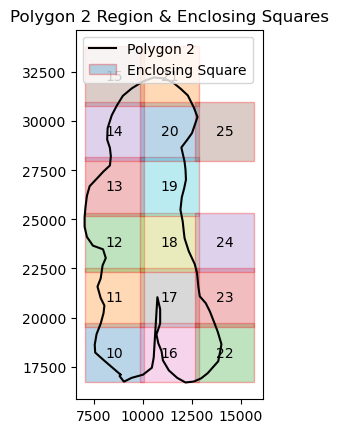

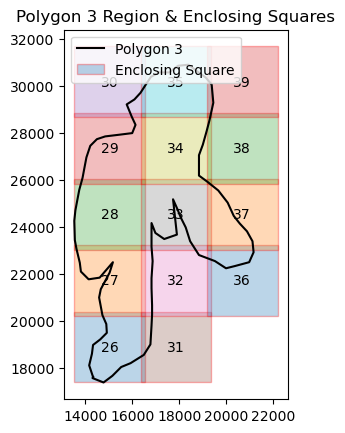

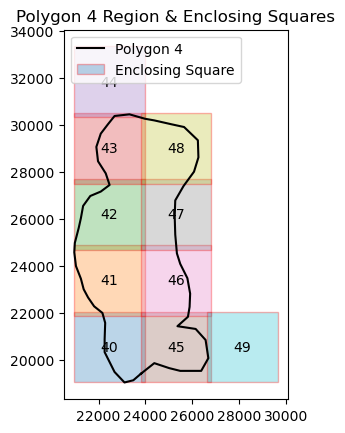

In [47]:
# Process all sections with continuous square numbering
polygon_number = 1
square_counter = 0  # Global square counter

for section in all_sections:
    
    # Get coordinates from section
    x_coords = section['x_coords']
    y_coords = section['y_coords']
    
    # Your original code block (unchanged)
    x_coords_rescaled = x_coords / pixelsize
    y_coords_rescaled = y_coords / pixelsize
    rescaled_polygon_roi = list(zip(x_coords_rescaled, y_coords_rescaled))
    
    # Create a Polygon object
    rescaled_polygon_roi = Polygon(rescaled_polygon_roi)
    
    # Define square size
    square_size = int(crop_size)
    overlap_size = 40/0.2125
    
    # Generate non-overlapping square regions
    overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, overlap_size=overlap_size, with_overlap=True)
    non_overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, with_overlap=False)
    
    # Plot with continuous numbering
    plot_polygon_and_squares_continuous(
        rescaled_polygon_roi,
        overlapping_squares,
        square_counter,  # Pass current counter
        title=f"Polygon {polygon_number} Region & Enclosing Squares",
        polygon_label=f"Polygon {polygon_number}",
        square_label="Enclosing Square"
    )
    
    # Update counters
    square_counter += len(overlapping_squares)  # Increment by number of squares
    polygon_number += 1

In [48]:
import tqdm

In [49]:
# import pandas as pd
# from shapely.geometry import Point, Polygon
# from shapely.prepared import prep

# # 1) Load your polygon
# polygon_coords = pd.read_csv(f"{base_path}/{sample_name}_coordinates.csv")
# polygon = Polygon(zip(polygon_coords['X'], polygon_coords['Y']))

# # 2) Build the bounding‐box filter
# minx, miny, maxx, maxy = polygon.bounds

# # 3) Prepare the polygon for fast repeated contains() checksimport pandas as pd
# from shapely.geometry import Point, Polygon
# from shapely.prepared import prep
# from tqdm import tqdm

# # Load transcripts once
# df = transcripts_b4_assign.copy()

# # Collect all filtered transcripts
# all_filtered_list = []

# # Process each section
# for section in all_sections:
#     print(f"\nProcessing {section['name']}...")
    
#     # 1) Create polygon for this section
#     polygon = Polygon(zip(section['x_coords'], section['y_coords']))
    
#     # 2) Build the bounding-box filter
#     minx, miny, maxx, maxy = polygon.bounds
    
#     # 3) Prepare the polygon for fast repeated contains() checks
#     prepared_poly = prep(polygon)
    
#     # 4) First, prefilter by bbox (very cheap)
#     mask_bbox = (
#         (df["x_location"] >= minx) &
#         (df["x_location"] <= maxx) &
#         (df["y_location"] >= miny) &
#         (df["y_location"] <= maxy)
#     )
#     df_bbox = df[mask_bbox]
    
#     print(f"{len(df_bbox)} of {len(df)} points lie in the bbox, now doing exact test...")
    
#     # 5) Now do the exact point-in-polygon test
#     filtered = []
#     for x, y in tqdm(zip(df_bbox["x_location"], df_bbox["y_location"]),
#                      total=len(df_bbox), 
#                      desc=f"Filtering {section['name']}"):
#         pt = Point(x, y)
#         if prepared_poly.contains(pt):
#             filtered.append(True)
#         else:
#             filtered.append(False)
    
#     transcripts_section = df_bbox[filtered]
#     print(f"Kept {len(transcripts_section)} points inside {section['name']}")
    
#     # Add to the master list
#     all_filtered_list.append(transcripts_section)

# # Combine all sections into one DataFrame
# transcripts_filtered = pd.concat(all_filtered_list, ignore_index=True)

# print(f"\n=== FINAL RESULT ===")
# print(f"Total transcripts_filtered: {len(transcripts_filtered)} transcripts from all sections")

# # Remove duplicates if any transcript appears in multiple sections
# transcripts_filtered = transcripts_filtered.drop_duplicates()
# print(f"After removing duplicates: {len(transcripts_filtered)} transcripts")
# prepared_poly = prep(polygon)

# # 4) Load transcripts
# df = transcripts_b4_assign.copy()

# # 5) First, prefilter by bbox (very cheap)
# mask_bbox = (
#     (df["x_location"] >= minx) &
#     (df["x_location"] <= maxx) &
#     (df["y_location"] >= miny) &
#     (df["y_location"] <= maxy)
# )
# df_bbox = df[mask_bbox]

# print(f"{len(df_bbox)} of {len(df)} points lie in the bbox, now doing exact test…")

# # 6) Now do the exact point-in-polygon test with a simple list comprehension
# from tqdm import tqdm
# filtered = []
# for x, y in tqdm(zip(df_bbox["x_location"], df_bbox["y_location"]),
#                  total=len(df_bbox)):
#     pt = Point(x, y)
#     if prepared_poly.contains(pt):
#         filtered.append(True)
#     else:
#         filtered.append(False)

# transcripts_filtered = df_bbox[filtered]
# print(f"Kept {len(transcripts_filtered)} points inside the actual polygon.")


In [50]:
from shapely.prepared import prep

# Load transcripts once
df = transcripts_b4_assign.copy()

# Collect all filtered transcripts
all_filtered_list = []

# Process each section (reuse existing polygon creation)
polygon_number = 1
square_counter = 0

for section in all_sections:
    
    # Get coordinates from section
    x_coords = section['x_coords']
    y_coords = section['y_coords']
    
    print(f"\nFiltering transcripts for Polygon {polygon_number}...")
    
    # Use ORIGINAL coordinates for transcript filtering (no pixelsize division)
    original_polygon = Polygon(zip(x_coords, y_coords))
    
    # Filter transcripts using the original polygon
    minx, miny, maxx, maxy = original_polygon.bounds
    prepared_poly = prep(original_polygon)
    
    # Prefilter by bbox
    mask_bbox = (
        (df["x_location"] >= minx) &
        (df["x_location"] <= maxx) &
        (df["y_location"] >= miny) &
        (df["y_location"] <= maxy)
    )
    df_bbox = df[mask_bbox]
    
    print(f"{len(df_bbox)} of {len(df)} points lie in the bbox, now doing exact test...")
    
    # Exact point-in-polygon test
    filtered = []
    for x, y in zip(df_bbox["x_location"], df_bbox["y_location"]):
        pt = Point(x, y)
        if prepared_poly.contains(pt):
            filtered.append(True)
        else:
            filtered.append(False)
    
    transcripts_section = df_bbox[filtered]
    print(f"Kept {len(transcripts_section)} points inside Polygon {polygon_number}")
    
    # Add to the master list
    all_filtered_list.append(transcripts_section)
    
    # Your existing square generation code (still uses rescaled coordinates)
    x_coords_rescaled = x_coords / pixelsize
    y_coords_rescaled = y_coords / pixelsize
    rescaled_polygon_roi = list(zip(x_coords_rescaled, y_coords_rescaled))
    rescaled_polygon_roi = Polygon(rescaled_polygon_roi)
    
    square_size = int(crop_size)
    overlap_size = 40/0.2125
    
    overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, overlap_size=overlap_size, with_overlap=True)
    non_overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, with_overlap=False)
    
    # Update counters
    square_counter += len(overlapping_squares)
    polygon_number += 1

# Combine all sections into one DataFrame
transcripts_filtered = pd.concat(all_filtered_list, ignore_index=True)

print(f"\n=== FINAL RESULT ===")
print(f"Total transcripts_filtered: {len(transcripts_filtered)} transcripts from all sections")

# Remove duplicates if any transcript appears in multiple sections
transcripts_filtered = transcripts_filtered.drop_duplicates()
print(f"After removing duplicates: {len(transcripts_filtered)} transcripts")


Filtering transcripts for Polygon 1...
4157539 of 38644131 points lie in the bbox, now doing exact test...
Kept 4136491 points inside Polygon 1

Filtering transcripts for Polygon 2...
5839782 of 38644131 points lie in the bbox, now doing exact test...
Kept 5817814 points inside Polygon 2

Filtering transcripts for Polygon 3...
5441326 of 38644131 points lie in the bbox, now doing exact test...
Kept 5275984 points inside Polygon 3

Filtering transcripts for Polygon 4...
5393750 of 38644131 points lie in the bbox, now doing exact test...
Kept 5381211 points inside Polygon 4

=== FINAL RESULT ===
Total transcripts_filtered: 20611500 transcripts from all sections
After removing duplicates: 20611500 transcripts


In [51]:
transcripts_filtered

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,codeword_index,codeword_category,is_gene
0,281625300566579,UNASSIGNED,0,Mbp,488.656250,3996.078125,12.515625,40.00,R2,96.750000,16289,custom_gene,True
1,281625300567245,bihlbfgg-1,0,A2m,453.156250,4196.765625,17.953125,40.00,R2,3.187500,15150,predesigned_gene,True
2,281625300570923,bihaaeam-1,0,A2m,451.546875,4228.093750,13.828125,40.00,R2,3.843750,15150,predesigned_gene,True
3,281625300583686,bialdnek-1,0,A2m,406.390625,4165.625000,14.906250,22.75,R2,0.011719,16219,predesigned_gene,True
4,281625300584918,bihlljgf-1,0,A2m,439.343750,4187.515625,13.406250,40.00,R2,0.406250,16219,predesigned_gene,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20611495,281659660323613,UNASSIGNED,0,Plxna1,5530.937500,4529.375000,13.828125,40.00,S11,12.296875,18033,predesigned_gene,True
20611496,281659660327254,UNASSIGNED,0,Rsrp1,5525.671875,4510.734375,13.812500,40.00,S11,31.671875,8224,predesigned_gene,True
20611497,281659660345424,UNASSIGNED,0,Washc2,5524.546875,4511.156250,14.359375,40.00,S11,31.593750,3003,predesigned_gene,True
20611498,281659660328812,UNASSIGNED,0,Ywhaz,5524.531250,4511.234375,13.875000,40.00,S11,31.531250,16974,predesigned_gene,True


In [52]:
transcripts_assigned = transcripts_filtered


In [53]:
import pandas as pd
from shapely.geometry import Point, Polygon
from rtree import index
from tqdm import tqdm

# 1) Build spatial index and polygon dict
spatial_idx = index.Index()
cell_polygons = {}

for cell_id, group in Outlines_list_final_scaled.groupby("cell_id"):
    poly = Polygon(zip(group["vertex_x"], group["vertex_y"]))
    cell_polygons[cell_id] = poly
    spatial_idx.insert(cell_id, poly.bounds)

# 2) Helper: single‐point lookup (no globals here)
def find_cell_id(x, y, spatial_index, polygons):
    pt = Point(x, y)
    # only test the few polygons whose bbox overlaps this point
    for cid in spatial_index.intersection((x, y, x, y)):
        if polygons[cid].contains(pt):
            return cid
    return "UNASSIGNED"

# 3) Main assigner with progress tracking
def assign_cell_ids_with_progress(df, spatial_index, polygons):
    """
    Iterates over df, finds each point’s cell_id via R-tree lookup,
    and shows a tqdm progress bar.
    Returns a list of cell_ids in the same order as df.
    """
    cell_ids = []
    # wrap the iterator in tqdm, giving a description and total count
    for row in tqdm(df.itertuples(index=False),
                    total=len(df),
                    desc="Assigning transcripts"):
        x, y = row.x_location, row.y_location
        pt = Point(x, y)
        # only test candidate polygons whose bbox overlaps this point
        cid = "UNASSIGNED"
        for candidate in spatial_index.intersection((x, y, x, y)):
            if polygons[candidate].contains(pt):
                cid = candidate
                break
        cell_ids.append(cid)

    return cell_ids

# Execution
transcripts_assigned["cell_id"] = assign_cell_ids_with_progress(
    transcripts_assigned,
    spatial_idx,
    cell_polygons
)
print("✅ Processing complete! All transcripts have been assigned a cell_id.")


Assigning transcripts: 100%|██████████| 20611500/20611500 [39:20<00:00, 8732.99it/s]  


✅ Processing complete! All transcripts have been assigned a cell_id.


In [54]:
transcripts_assigned_true = transcripts_assigned[transcripts_assigned["cell_id"] != "UNASSIGNED"]
transcripts_assigned_true

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,codeword_index,codeword_category,is_gene
3,281625300583686,5200,0,A2m,406.390625,4165.625000,14.906250,22.75,R2,0.011719,16219,predesigned_gene,True
4,281625300584918,5217,0,A2m,439.343750,4187.515625,13.406250,40.00,R2,0.406250,16219,predesigned_gene,True
6,281625300579166,5186,0,Aatf,399.328125,4153.546875,19.437500,40.00,R2,1.734375,487,predesigned_gene,True
7,281625300587511,5241,0,Aatf,468.078125,4223.234375,16.453125,40.00,R2,0.875000,487,predesigned_gene,True
8,281625300569024,5209,1,Aatf,427.875000,4178.796875,16.109375,22.75,R2,0.000000,6462,predesigned_gene,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20611469,281659660348761,20322,0,UnassignedCodeword_6619,5508.109375,4447.828125,16.953125,23.75,S11,4.125000,6619,unassigned_codeword,False
20611470,281659660322487,20226,0,UnassignedCodeword_8366,5533.687500,4375.250000,14.140625,22.75,S11,0.984375,8366,unassigned_codeword,False
20611473,281621005615487,20145,0,UnassignedCodeword_15346,5542.187500,4329.515625,16.718750,22.00,R11,0.781250,15346,unassigned_codeword,False
20611476,281621005632039,20189,1,DeprecatedCodeword_0321,5512.234375,4356.000000,17.703125,40.00,R11,0.000000,321,deprecated_codeword,False


In [55]:
import pandas as pd
import os

def create_folder_if_not_exists(path):
    """Create folder if it doesn't exist."""
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory: {path}")

gene_output_dir = f"{ddir}/gene_expression_matrix/{sample_name}"
create_folder_if_not_exists(gene_output_dir)

Created directory: D:\Alexis\Projects\SpatialOmics_cellpose\results/gene_expression_matrix/0058077_ivCL_DRGs_1


In [56]:
# Assuming transcripts_assigned_ture is your DataFrame
output_path = f"{ddir}/gene_expression_matrix/{sample_name}/transcripts_assigned_ture.parquet"

# Save the DataFrame as a Parquet file
transcripts_assigned_true.to_parquet(output_path, engine='pyarrow', index=False)

print(f"DataFrame saved successfully to {output_path}")

DataFrame saved successfully to D:\Alexis\Projects\SpatialOmics_cellpose\results/gene_expression_matrix/0058077_ivCL_DRGs_1/transcripts_assigned_ture.parquet


In [57]:
# Merge with centroids to add centroid coordinates, and scale centroid_x and centroid_y by 0.2125
centroids_df_scaled = centroids_df.copy()
centroids_df_scaled["centroid_x"] = centroids_df_scaled["centroid_x"] * 0.2125
centroids_df_scaled["centroid_y"] = centroids_df_scaled["centroid_y"] * 0.2125

In [58]:
transcripts_data = transcripts_assigned_true

# Create a pivot table for the gene expression matrix
gene_expression_matrix = (
    transcripts_data.groupby(["cell_id", "feature_name"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Add total counts column

gene_expression_matrix["Total Counts"] = gene_expression_matrix.drop(columns=["cell_id"]).sum(axis=1)
# Merge with centroids to add centroid coordinates
gene_expression_matrix = pd.merge(
    
    centroids_df_scaled,
    gene_expression_matrix,
    left_on="cell_id", 
    right_on="cell_id", 
    how='left')

In [59]:
gene_expression_matrix

,cell_id,centroid_x,centroid_y,A1cf,A2m,Aatf,Abca1,Abca13,Abca3,Abca4,...,Zp3,Zscan2,Zscan21,Zswim5,Zswim9,Zup1,Zyx,Zzef1,a,Total Counts
0,1,974.554266,6352.919087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0
1,2,987.919300,6353.347100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,949.165625,6355.695833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0
3,4,922.680060,6363.354874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,372.0
4,5,935.100658,6355.023136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24380,24381,996.122842,6383.818750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0
24381,24382,948.548130,6382.251772,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,662.0
24382,24383,1001.005512,6385.466043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0
24383,24384,1134.784274,6385.309677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [60]:
later_columns = gene_expression_matrix.columns[1:]

In [61]:
# Fill empty values with 0 for all columns after column 4
gene_expression_matrix[later_columns] = gene_expression_matrix[later_columns].fillna(0)

# Verify the changes
print("\nChecking if there are still any empty values:")
print(gene_expression_matrix[later_columns].isna().sum())

# Display a few rows to verify the changes
print("\nFirst few rows after filling empty values:")
print(gene_expression_matrix.head())


Checking if there are still any empty values:
centroid_x      0
centroid_y      0
A1cf            0
A2m             0
Aatf            0
               ..
Zup1            0
Zyx             0
Zzef1           0
a               0
Total Counts    0
Length: 11400, dtype: int64

First few rows after filling empty values:
   cell_id  centroid_x   centroid_y  A1cf  A2m  Aatf  Abca1  Abca13  Abca3  \
0        1  974.554266  6352.919087   0.0  0.0   0.0    0.0     0.0    0.0   
1        2  987.919300  6353.347100   0.0  0.0   0.0    0.0     0.0    0.0   
2        3  949.165625  6355.695833   0.0  0.0   0.0    0.0     0.0    0.0   
3        4  922.680060  6363.354874   0.0  0.0   0.0    0.0     0.0    0.0   
4        5  935.100658  6355.023136   0.0  0.0   0.0    0.0     0.0    0.0   

   Abca4  ...  Zp3  Zscan2  Zscan21  Zswim5  Zswim9  Zup1  Zyx  Zzef1    a  \
0    0.0  ...  0.0     0.0      0.0     0.0     0.0   0.0  0.0    0.0  0.0   
1    0.0  ...  0.0     0.0      0.0     0.0     0.0   0.0 

In [62]:
import pandas as pd

# Change the file extension to .parquet
output_path = rf"{ddir}/gene_expression_matrix/{sample_name}/{sample_name}_gene_expression_matrix.parquet"

# Save as Parquet (much faster)
gene_expression_matrix.to_parquet(output_path, index=False)

print(f"DataFrame saved successfully to {output_path}")

DataFrame saved successfully to D:\Alexis\Projects\SpatialOmics_cellpose\results/gene_expression_matrix/0058077_ivCL_DRGs_1/0058077_ivCL_DRGs_1_gene_expression_matrix.parquet


In [63]:
# import pandas as pd

# # Assuming transcripts_assigned_ture is your DataFrame
# output_path = rf"{ddir}/gene_expression_matrix/{sample_name}/{sample_name}_gene_expression_matrix.csv"

# # Save the DataFrame as a Parquet file
# gene_expression_matrix.to_csv(output_path, index=False)

# print(f"DataFrame saved successfully to {output_path}")

In [64]:
from shapely.geometry import Point, Polygon
import pandas as pd

# Dictionary to store cell IDs for each polygon
polygon_cell_lists = {}

for section in all_sections:
    # Get coordinates and name from section
    x_coords = section['x_coords']
    y_coords = section['y_coords']
    polygon_name = section['name']  # Use the actual name from the section
    
    # Rescale coordinates (same as your code)
    x_coords_rescaled = x_coords / pixelsize
    y_coords_rescaled = y_coords / pixelsize
    rescaled_polygon_roi = list(zip(x_coords_rescaled, y_coords_rescaled))
    
    # Create a Polygon object
    rescaled_polygon_roi = Polygon(rescaled_polygon_roi)
    
    # Find all cells whose centroids are inside this polygon
    cells_in_polygon = []
    
    for idx, row in centroids_df.iterrows():
        # Create point from centroid coordinates
        centroid_point = Point(row['centroid_x'], row['centroid_y'])
        
        # Check if point is inside polygon
        if rescaled_polygon_roi.contains(centroid_point):
            cells_in_polygon.append(row['cell_id'])
    
    # Store the list of cell IDs for this polygon
    polygon_cell_lists[polygon_name] = cells_in_polygon
    
    # Print summary
    print(f"{polygon_name}: {len(cells_in_polygon)} cells")

# Access results:
# polygon_cell_lists['Selection 1'] will contain all cell IDs whose centroids are inside Selection 1

Selection 1: 4668 cells
Selection 2: 6034 cells
Selection 3: 6109 cells
Selection 4: 5781 cells


In [65]:
polygon_cell_lists['Selection 1']

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 5081.0,
 5083.0,
 5086.0,
 5087.0,
 5090.0,
 5091.0,
 5093.0,
 5094.0,
 5098.0,
 5101.0,
 5102.0,
 5104.0,
 5105.0,
 5106.0,
 5107.0,
 5109.0,
 5111.0,
 5112.0,
 5117.0,
 5123.0,
 5126.0,
 5127.0,
 5130.0,
 5133.0,
 5134.0,
 5135.0,
 5136.0,
 5137.0,
 5138.0,
 5141.0,
 5142.0,
 5143.0,
 5144.0,
 5145.0,
 5146.0,
 5147.0,
 5148.0,
 5149.0,
 5150.0,
 5151.0,
 5152.0,
 5153.0,
 5154.0,
 5155.0,
 5156.0,
 5157.0,
 5158.0,
 5159.0,
 5160.0,
 5161.0,
 5162.0,
 5163.0,
 5164.0,
 5165.0,
 5166.0,
 5167.0,
 5168.0,
 5169.0,
 5170.0,
 5171.0,
 5172.0,
 5173.0,
 5174.0,
 5175.0,
 5176.0,
 5177.0,
 5178.0,
 5179.0,
 5180.0,
 5181.0,
 5182.0,
 5183.0,
 518

In [66]:
# Save cell boundaries for each polygon region
for polygon_name, cell_ids in polygon_cell_lists.items():
    if len(cell_ids) > 0:  # Only save if there are cells in this region
        # Filter boundaries for cells in this polygon
        region_boundaries = Outlines_list_final_scaled[
            Outlines_list_final_scaled['cell_id'].isin(cell_ids)
        ]
        
        # Create filename for this region
        region_filename = f'{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_{sample_name}_{polygon_name.replace(" ", "_")}.csv'
        
        # Save to CSV
        region_boundaries.to_csv(region_filename, index=False)
        
        print(f"Saved {polygon_name}: {len(cell_ids)} cells, {len(region_boundaries)} boundary points")
    else:
        print(f"Skipped {polygon_name}: No cells found")

print("All region boundary files saved successfully!")

Saved Selection 1: 4668 cells, 615978 boundary points
Saved Selection 2: 6034 cells, 840697 boundary points
Saved Selection 3: 6109 cells, 862178 boundary points
Saved Selection 4: 5781 cells, 828062 boundary points
All region boundary files saved successfully!


In [67]:
import pandas as pd

# Save gene expression matrix for each polygon region
for polygon_name, cell_ids in polygon_cell_lists.items():
    if len(cell_ids) > 0:  # Only save if there are cells in this region
        # Filter gene expression matrix for cells in this polygon
        region_gene_expression = gene_expression_matrix[
            gene_expression_matrix['cell_id'].isin(cell_ids)
        ]
        
        # Create filename for this region (using parquet format)
        region_filename = f'{ddir}/gene_expression_matrix/{sample_name}/{sample_name}_gene_expression_matrix_{polygon_name.replace(" ", "_")}.parquet'
        
        # Save as Parquet
        region_gene_expression.to_parquet(region_filename, index=False)
        
        print(f"Saved {polygon_name}: {len(cell_ids)} cells, {region_gene_expression.shape[1]} columns")
    else:
        print(f"Skipped {polygon_name}: No cells found")

print("All region gene expression files saved successfully!")

Saved Selection 1: 4668 cells, 11401 columns
Saved Selection 2: 6034 cells, 11401 columns
Saved Selection 3: 6109 cells, 11401 columns
Saved Selection 4: 5781 cells, 11401 columns
All region gene expression files saved successfully!
